# Проект - Определение стоимости автомобилей

## Описание проекта

1. Сервис по продаже автомобилей с пробегом разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
2. Нужно построить модель, которая умеет её определять. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.
3. Критерии, которые важны заказчику:
    - качество предсказания;
    - время обучения модели;
    - время предсказания модели.

## Основные шаги

1. Загрузим данные
2. Изучим данные, заполнить пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неимформативные их следует удалить
3. Подготовим выборки для обучения моделей
4. Обучитм разные модели, одна из которых - LightGBM, как минимум одна - не бустинг. Для каждой модели попробуем разные гиперпараметры
5. Проанализируем время обучения, время предсказания и качество моделей
6. Опираясь на критерии заказчика, выберем лучшую модель, проверим ее качество на тестовой выборке


## Описание данных

1. **Признаки**
    - DateCrawled — дата скачивания анкеты из базы
    - VehicleType — тип автомобильного кузова
    - RegistrationYear — год регистрации автомобиля
    - Gearbox — тип коробки передач
    - Power — мощность (л. с.)
    - Model — модель автомобиля
    - Kilometer — пробег (км)
    - RegistrationMonth — месяц регистрации автомобиля
    - FuelType — тип топлива
    - Brand — марка автомобиля
    - Repaired — была машина в ремонте или нет
    - DateCreated — дата создания анкеты
    - NumberOfPictures — количество фотографий автомобиля
    - PostalCode — почтовый индекс владельца анкеты (пользователя)
    - LastSeen — дата последней активности пользователя
2. **Целевой признак**
    - Price - цена (евро)

# Выполнение проекта

## Выгрузка необходимых библиотек

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
import time
def exec_time(start, end):
   diff_time = end - start
   m, s = divmod(diff_time, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))
   return("{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

## Загрузка данных

- Загрузим данные

In [4]:
try:
    data=pd.read_csv('C:/Users/kaz-106/YandexDisk/Py-projects/02_Practicum projects/09_Numerical_methods/autos.csv')
except:
    data=pd.read_csv('/datasets/autos.csv')

## Предобработка данных

In [5]:
print(data.dtypes)
print(data.info())
display(data.head())

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
Repaired             object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  ob

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Выделение необходимых столбцов

    - DateCrawled — дата скачивания анкеты из базы - врядли влияет на цену - удаляем
    - VehicleType — тип автомобильного кузова - оставляем
    - RegistrationYear — год регистрации автомобиля - оставляем
    - Gearbox — тип коробки передач - оставляем
    - Power — мощность (л. с.) - оставляем
    - Model — модель автомобиля - оставляем
    - Kilometer — пробег (км) - оставляем
    - RegistrationMonth — месяц регистрации автомобиля - возможно на цену авто влияет сезонность - оставляем
    - FuelType — тип топлива - оставляем
    - Brand — марка автомобиля - оставялем
    - Repaired — была машина в ремонте или нет - оставляем
    - DateCreated — дата создания анкеты - врядли влияет на цену - удаляем
    - NumberOfPictures — количество фотографий автомобиля - больше фото - лучше качество объявления - оставляем
    - PostalCode — почтовый индекс владельца анкеты (пользователя). Нам неизвестно распределение по странам или типам индексов, а системы кодирования везде разные - удаляем
    - LastSeen — дата последней активности пользователя - врядли влияет на цену - удаляем

In [6]:
data = data.drop(['DateCrawled','DateCreated','PostalCode','LastSeen'], axis=1)

### Обработка пропусков

In [7]:
data.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
NumberOfPictures         0
dtype: int64

В данных довольно много пропусков, посмотрим как их можно обработать. Посмотрим, какой процент пропусков по столбцам

In [8]:
nan_lines = (data.isna().sum()/data.shape[0])*100
display(nan_lines)

Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
Repaired             20.079070
NumberOfPictures      0.000000
dtype: float64

In [9]:
display(data.Repaired.unique())

array([nan, 'yes', 'no'], dtype=object)

#### Пропуски в столбце "Repaired"
- предположим, что если машина не ремонтировалась, то при заполнении анкеты автор оставлял это поле пустым, значит можно заменить NaN на no

In [10]:
data['Repaired'] = data['Repaired'].fillna("no")

#### Пропуски в столбце "VehicleType"
- Nan можно перевести в категорию Other

In [11]:
display(data.VehicleType.unique())

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [12]:
data['VehicleType'] = data['VehicleType'].fillna("other")

In [13]:
display(data.Gearbox.unique())

array(['manual', 'auto', nan], dtype=object)

#### Пропуски в столбце "Gearbox"
- Ничего не поделать - придется удалить пропуски

In [14]:
data = data.dropna(subset=['Gearbox'])

In [15]:
display(data.FuelType.unique())

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

#### Пропуски в столбце "FuelType"
- Nan можно перевести в категорию Other

In [16]:
data['FuelType'] = data['FuelType'].fillna("other")

In [17]:
display(data.Model.unique())

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter', 'punto',
       'e_klasse', 'clio', 'kadett', 'one', 'fortwo', '1er', 'b_klasse',
       'signum', 'astra', 'a8', 'jetta', 'polo', 'fiesta', 'c_klasse',
       'micra', 'vito', 'sprinter', '156', 'escort', 'forester',
       'xc_reihe', 'scenic', 'a4', 'a1', 'combo', 'focus', 'tt', 'a6',
       'jazz', 'omega', 'slk', '7er', 'corsa', '80', '147', 'z_reihe',
       'sportage', 'sorento', 'v40', 'ibiza', 'mustang', 'eos', 'touran',
       'getz', 'insignia', 'ka', 'almera', 'megane', 'a3', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'sharan', '6_reihe',
       'panda', 'up', 'seicento', 'ceed', 'kangoo', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox', 'matiz',
      

#### Пропуски в столбце "Model"
- Просто удаляем

In [18]:
data = data.dropna(subset=["Model",])

Проверим оставшиеся пропуски

data.isna().sum()

In [19]:
data.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
NumberOfPictures     0
dtype: int64

### Обработка дубликатов

- проверим количество дубликатов

In [20]:
data.duplicated().sum()

27971

Удалим дубликаты

In [21]:
data=data.drop_duplicates()
data.duplicated().sum()

0

## Исследовательский анализ данных

In [22]:
display(data.head())
data.describe()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,NumberOfPictures
0,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,no,0
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,0


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures
count,290991.000000,290991.000000,290991.000000,290991.000000,290991.000000,290991.0
mean,4595.355891,2003.405607,114.836318,128727.864436,5.884185,0.0
std,4571.414286,30.560506,192.496951,36747.778989,3.638763,0.0
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0
25%,1200.000000,1999.000000,75.000000,125000.000000,3.000000,0.0
50%,2900.000000,2003.000000,105.000000,150000.000000,6.000000,0.0
75%,6650.000000,2008.000000,143.000000,150000.000000,9.000000,0.0
max,20000.000000,9000.000000,20000.000000,150000.000000,12.000000,0.0


### Обработка выбросов

- Выбросы можно обработать только в количественных признаках

In [23]:
data_numerical = data[['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures']]


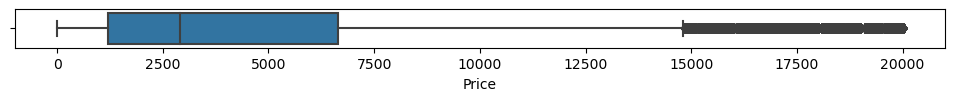

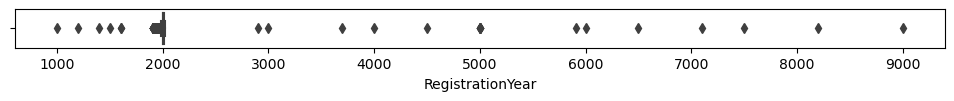

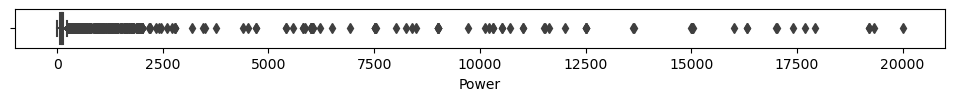

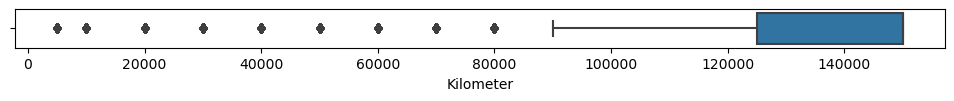

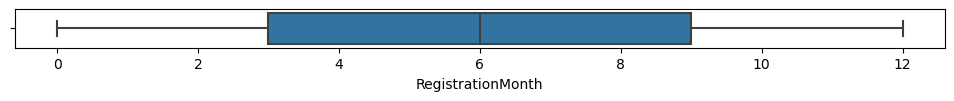

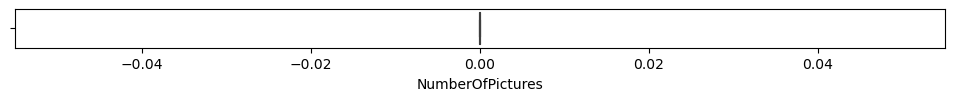

In [24]:
for i in list(data_numerical.columns):
    plt.figure(figsize=(12,.5))
    sns.boxplot(data[i]);
    plt.show()

#### Выбросы в столбце "Price"
- Машины не могут продаваться по цене 0 Евро. Установим нижнюю границу в 250 Евро (20 000 руб)

<AxesSubplot:xlabel='Price'>

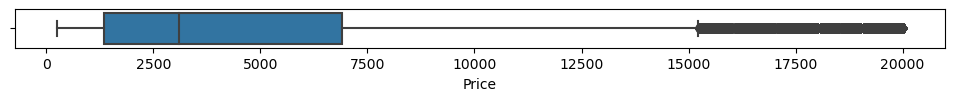

In [25]:
data = data.query('250 < Price')
plt.figure(figsize=(12,.5))
sns.boxplot(data['Price'])

#### Выбросы в столбце "Registration Year"
- Сейчас 2023 год. Самое раннее авто, представленное на Авто.ру - Opel Olympia, 1935 года. Ограничимся этими годами.

<AxesSubplot:xlabel='RegistrationYear'>

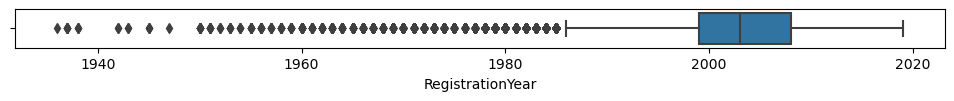

In [26]:
data = data.query('1935 < RegistrationYear < 2035')
plt.figure(figsize=(12,.5))
sns.boxplot(data['RegistrationYear'])

#### Выбросы в столбце "Power"
- Самые слабые авто на Авто.ру - СМЗ по 10 л.с. Самые мощные - Tesla по 1020 л.с. Ограничимся этими параметрами

<AxesSubplot:xlabel='Power'>

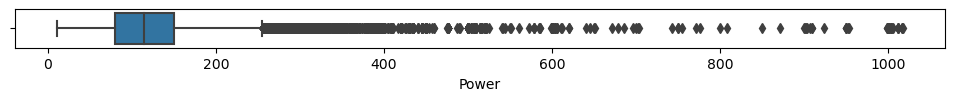

In [27]:
data = data.query('10 < Power < 1020')
plt.figure(figsize=(12,.5))
sns.boxplot(data['Power'])

#### Выбросы в столбце "Kilometer"
- Здесь все данные корректны

#### Выбросы в столбце "NumberOfPictures"
- В этом столбце одни нули, либо данные неправильно выгрузились, либо стобец не участвует в заполнении анкеты. Придется его просто удалить

In [28]:
display(data["NumberOfPictures"].unique())

array([0], dtype=int64)

In [29]:
data = data.drop(["NumberOfPictures"], axis=1)

#### Проверка выбросов после очистки

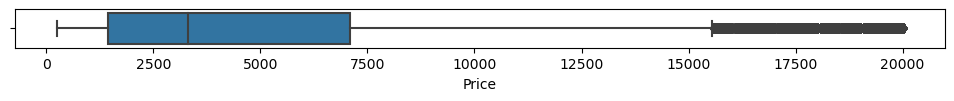

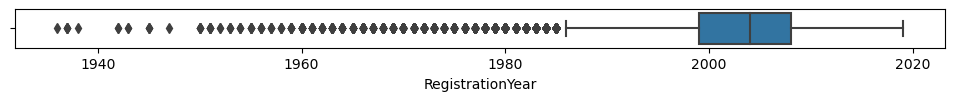

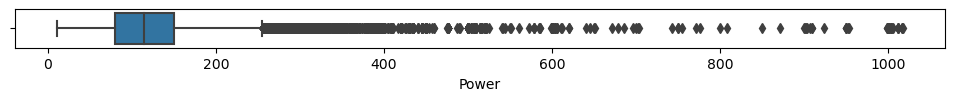

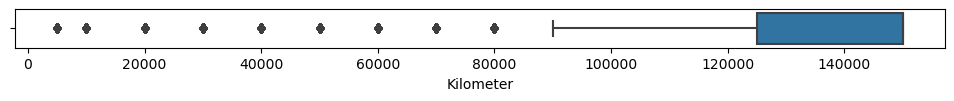

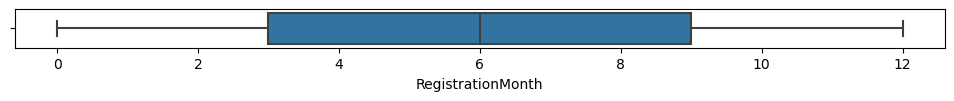

In [30]:
data_numerical = data[['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']]
for i in list(data_numerical.columns):
    plt.figure(figsize=(12,.5))
    sns.boxplot(data[i]);
    plt.show()

## Преобработка и анализ - выводы

- Обработаны пропуски, nan заменены на other где возможно
- Удалены дубликаты
- Удалены выбросы/некорректные значения
- Все типы данных корректны и не требуют обработки

## Подготовка и обучение моделей

### Разделение данных на выборки и выделим признаки
- Разделим данные в соотношении 60:20:20
- Выделим целевой признак

In [31]:
features = data.drop(['Price'], axis = 1)  
target = data['Price'] 

features_train, features_valid, target_train, target_valid = train_test_split(features,target, test_size=0.2,train_size=0.8,random_state=123)
features_train, features_test, target_train, target_test = train_test_split(features_train, target_train, test_size=0.25,train_size=0.75,random_state=123)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(154284, 10)
(51428, 10)
(51428, 10)


### Обучение моделей и подбор гиперпараметров

#### LGBMRegressor

- Судя по документации LGBMRegressor не требует кодирования категориальных признаков
- categorical_feature — принимает список строк/целых чисел или строку auto. Если мы передадим список строк/целых чисел, тогда указанные столбцы из набора данных будут рассматриваться как категориальные.

In [32]:
display(features_train.head(1))
categorical_features = [0,2,4,7,8,9]
print(categorical_features)
for i in ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']:
    features_train[i]=features_train[i].astype('category')
    features_valid[i]=features_valid[i].astype('category')
    features_test[i]=features_test[i].astype('category')


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
229474,bus,2008,manual,105,caddy,150000,9,gasoline,volkswagen,no


[0, 2, 4, 7, 8, 9]


In [33]:
%%time

start = time.time() 

LGBM_model = lgb.LGBMRegressor(num_leaves= 100, learning_rate=0.05, max_depth=15, n_estimators=100)
LGBM_model.fit(features_train, target_train, eval_metric='rmse', categorical_feature=categorical_features)

end = time.time()

LGBM_learn=exec_time(start,end)

print(LGBM_learn)

Time: 00:00:01
00:00:01
Wall time: 864 ms


In [34]:
%%time

start = time.time() 

predicted_test_LGBM = LGBM_model.predict(features_test)

end = time.time()

print('RMSE for LGBMR -> test:', mean_squared_error(target_test, predicted_test_LGBM) ** 0.5)

LGBM_predict=exec_time(start,end)
LGBM_RMSE=mean_squared_error(target_test, predicted_test_LGBM) ** 0.5
print(LGBM_predict)

RMSE for LGBMR -> test: 1590.230446012981
Time: 00:00:00
00:00:00
Wall time: 135 ms


Попробуем подбор параметров с помощью GridSearh. (Код закомментирован для экономии времени выполнения кода)

In [35]:
#%%time
#param_grid = {'max_depth':[5,15],
#              'learning_rate': [0.05,0.1],
#              }
#LGBM_model = lgb.LGBMRegressor()
#                                  
#parameters_LGBM = GridSearchCV(estimator = LGBM_model,param_grid = param_grid,n_jobs=1,verbose=10,scoring= 'neg_root_mean_squared_error',cv=5)
#
#parameters_LGBM.fit(features_train, target_train)
#print('best params\n', parameters_LGBM.best_params_)
#print('best RMSE\n', parameters_LGBM.best_score_)

#### CatBoost

- Судя по документации CatBoost также не требует кодирования категориальных признаков

In [36]:
%%time

start = time.time() 

CatBoost_model = CatBoostRegressor(iterations = 150, l2_leaf_reg=10, max_depth=10,loss_function = 'RMSE',eval_metric = 'RMSE')
CatBoost_model.fit(features_train, target_train, cat_features=categorical_features,verbose=10)

end = time.time()
CatBoost_learn=exec_time(start,end)


0:	learn: 4518.5271637	total: 230ms	remaining: 34.3s
10:	learn: 3701.4629857	total: 945ms	remaining: 11.9s
20:	learn: 3128.2722842	total: 1.73s	remaining: 10.6s
30:	learn: 2737.6072284	total: 2.45s	remaining: 9.39s
40:	learn: 2449.9085138	total: 3.18s	remaining: 8.45s
50:	learn: 2247.9879071	total: 3.86s	remaining: 7.49s
60:	learn: 2108.1491910	total: 4.48s	remaining: 6.54s
70:	learn: 2004.4123930	total: 5.1s	remaining: 5.67s
80:	learn: 1931.1207134	total: 5.73s	remaining: 4.88s
90:	learn: 1870.5084967	total: 6.34s	remaining: 4.11s
100:	learn: 1831.1413387	total: 6.95s	remaining: 3.37s
110:	learn: 1802.0643187	total: 7.55s	remaining: 2.65s
120:	learn: 1779.9411710	total: 8.18s	remaining: 1.96s
130:	learn: 1760.8609006	total: 8.87s	remaining: 1.29s
140:	learn: 1745.7219383	total: 9.58s	remaining: 611ms
149:	learn: 1734.6143450	total: 10.2s	remaining: 0us
Time: 00:00:10
Wall time: 10.5 s


In [37]:
%%time

start = time.time() 

predicted_test_CatBoost = CatBoost_model.predict(features_test)

end = time.time()

CatBoost_predict=exec_time(start,end)

print('RMSE for CatBoost -> test:', mean_squared_error(target_test, predicted_test_CatBoost) ** 0.5)

CatBoost_RMSE=mean_squared_error(target_test, predicted_test_CatBoost) ** 0.5

Time: 00:00:00
RMSE for CatBoost -> test: 1764.3770163619367
Wall time: 62.6 ms


Попробуем подбор параметров с помощью GridSearh. (Код закомментирован для экономии времени выполнения кода)

In [38]:
#%%time
#param_grid = {'l2_leaf_reg':[10,15],
#              'max_depth': [10,15],
#              }
#CatBoost_model = CatBoostRegressor(loss_function="RMSE", iterations=50,cat_features=categorical_features)
#                                  
#parameters_CatBoost = GridSearchCV(estimator = CatBoost_model,param_grid = param_grid,n_jobs=1,scoring= 'neg_root_mean_squared_error',cv=5)
#
#parameters_CatBoost.fit(features_train, target_train)
#print('best params\n', parameters_CatBoost.best_params_)
#print('best RMSE\n', parameters_CatBoost.best_score_)

#### Случайный лес

- Для случайного леса придется кодировать категориальные признаки, используем OHE кодирование
- Разделим кодированные данные на датасеты
- Количественные признаки имеют разный масшаб, но для модели случайного леса масшабирование не требуется

In [39]:
data_ord=data.copy()

encoder = OrdinalEncoder()

cat_columns = ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']

data_ord[cat_columns]=encoder.fit_transform(data_ord[cat_columns])

display(data.head())

features_ord = data_ord.drop(['Price'], axis = 1)  
target_ord = data_ord['Price'] 

features_train_ord, features_valid_ord, target_train_ord, target_valid_ord = train_test_split(features_ord,target_ord, test_size=0.2,train_size=0.8,random_state=123)
features_train_ord, features_test_ord, target_train_ord, target_test_ord = train_test_split(features_train_ord, target_train_ord, test_size=0.25,train_size=0.75,random_state=123)

print(features_train_ord.shape)
print(features_valid_ord.shape)
print(features_test_ord.shape)



,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no


(154284, 10)
(51428, 10)
(51428, 10)


In [40]:
#data_ohe=pd.get_dummies(data, drop_first=True)
#display(data_ohe.head())

#features_ohe = data_ohe.drop(['Price'], axis = 1)  
#target_ohe = data_ohe['Price'] 

#features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features_ohe,target_ohe, test_size=0.2,train_size=0.8,random_state=123)
#features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_train_ohe, target_train_ohe, test_size=0.25,train_size=0.75,random_state=123)

#print(features_train_ohe.shape)
#print(features_valid_ohe.shape)
#print(features_test_ohe.shape)

In [41]:
%%time

start = time.time() 

RandomForest_model = RandomForestRegressor(max_depth=10, random_state = 12345)
RandomForest_model.fit(features_train_ord, target_train_ord)

end = time.time()
RandomForest_learn=exec_time(start,end)

Time: 00:00:20
Wall time: 19.9 s


In [42]:
%%time

start = time.time() 

predicted_test_RandomForest = RandomForest_model.predict(features_test_ord)

end = time.time()
RandomForest_predict=exec_time(start,end)

print('RMSE for RandomForest -> test:', mean_squared_error(target_test_ord, predicted_test_RandomForest) ** 0.5)


RandomForest_RMSE=mean_squared_error(target_test, predicted_test_RandomForest) ** 0.5

Time: 00:00:01
RMSE for RandomForest -> test: 1876.7148825127535
Wall time: 513 ms


Линейная модель заведомо медленнее бустинговых, остановимся на заданных гиперпараметрах

### Анализ рассмотренных моделей

- Были обучены и подобраны гиперпараметры для трех моделей
    - LGBM
    - CatBoost
    - Случайный лес
- Бустинговая модель LGBM показала как наилучшее время обучения так и лучшую RMSE, с другой стороны, у CatBoost несколько лучшее время предсказания
- По сочетанию трех показателей (время обучения, время предсказания, качество модели) для финального тестирования будем использовать LGBM


In [43]:
result = {'Модель':['LGBM','CatBoost','Случайный лес'],
          'Скорость обучения':[LGBM_learn,CatBoost_learn,RandomForest_learn],
          'Скорость предсказания':[LGBM_predict,CatBoost_predict,RandomForest_predict],
          'RMSE':[LGBM_RMSE,CatBoost_RMSE,RandomForest_RMSE]}

result=pd.DataFrame(result)

display(result)

,Модель,Скорость обучения,Скорость предсказания,RMSE
0,LGBM,00:00:01,00:00:00,1590.230446
1,CatBoost,00:00:10,00:00:00,1764.377016
2,Случайный лес,00:00:20,00:00:01,1876.714883


## Финальное тестирование модели

In [44]:
%%time

LGBM_model = lgb.LGBMRegressor(num_leaves= 100, learning_rate=0.1, max_depth=15, n_estimators=300)
LGBM_model.fit(features_train, target_train, eval_metric='rmse', categorical_feature=categorical_features)
predicted_valid_LGBM = LGBM_model.predict(features_valid)

print('RMSE for LGBMR -> valid:', mean_squared_error(target_valid, predicted_valid_LGBM) ** 0.5)

RMSE for LGBMR -> valid: 1535.6947481666714
Wall time: 3.17 s


## Выводы

- Проведены предобработка и анализ представленных данных с помощью различных моделей машинного обучения, по каждому этапу представлены промежуточные выводы
- В данной задаче, по критериям, требуемым заказчиком наиболее подходящей моделью является LGBM, она показывает наилучшее быстродействие и качество обучения